In [1]:
# !pip install --upgrade pip

TEST_MODE = 0 # Testing macro

import os
import numpy as np # linear algebraf
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import warnings
import random
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle as sklearn_shuffle

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense,
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Lambda,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling1D,
    Activation
)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Ftrl, Nadam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import concatenate as keras_concat
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from functools import partial as partial_func



pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns


import time
import json

from matplotlib.ticker import MaxNLocator
from pandas.testing import assert_frame_equal

%run ./Preprocessing_utility-functions.ipynb
%run ./SEED-CONSTANTS.ipynb

print(f"\x1b[32mSEED: {SEED}\x1b[0m")
# Global utitlity functions are in separate notebook
if TEST_MODE: print("setup complete")

SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.333, Threshold: 1.000 <-- Worse case
--------------------Utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Preprocessing utility functions imported--------------------
SEED: 567
--------------------SEED and CONSTANTS imported--------------------
SEED: 567


In [5]:
!python --version

Python 3.9.10


In [6]:
def k_euclidean_dist(t):
    x = t[0]
    y = t[1]    
    return K.sqrt(K.sum(K.square(x - y), axis=-1, keepdims=True))

def k_manhattan_dist(t):
    x = t[0]
    y = t[1]
    return K.sum(K.abs(x - y), axis=-1, keepdims=True)


def k_contrastive_loss(y_true, dist, margin):
    """Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    return K.mean(y_true * K.square(dist) + (1 - y_true) * K.square(K.maximum(margin - dist, 0)))

def contrastive_loss_test(y_true, dist, margin=1):
    """Test function above using implementation with numpy instead tensors."""
    return y_true * np.square(dist) + (1 - y_true) * np.square(np.max(margin - dist, 0))

if TEST_MODE:
    print("Positive: class=1, distance=0,     loss:", contrastive_loss_test(1, 0))
    print("Positive: class=1, distance=0.01,  loss:", contrastive_loss_test(1, 0.01))
    print("Positive: class=1, distance=0.3,   loss:", contrastive_loss_test(1, 0.3))
    print("Positive: class=1, distance=0.5,   loss:", contrastive_loss_test(1, 0.5))
    print("Positive: class=1, distance=1,     loss:", contrastive_loss_test(1, 1))

    print("Negative: class=0, distance=0,     loss:", contrastive_loss_test(0, 0))
    print("Negative: class=0, distance=0.01,  loss:", contrastive_loss_test(0, 0.01))
    print("Negative: class=0, distance=0.3,   loss:", contrastive_loss_test(0, 0.3))
    print("Negative: class=0, distance=0.5,   loss:", contrastive_loss_test(0, 0.5))
    print("Negative: class=0, distance=1,     loss:", contrastive_loss_test(0, 1))




    print("Positive: class=1, distance=0,     loss:", k_contrastive_loss(tf.constant(1, dtype=tf.float32), tf.constant(0, dtype=tf.float32), 1))
    print("Positive: class=1, distance=0.01,  loss:", k_contrastive_loss(tf.constant(1, dtype=tf.float32), tf.constant(0.01, dtype=tf.float32), 1))
    print("Positive: class=1, distance=0.3,   loss:", k_contrastive_loss(tf.constant(1, dtype=tf.float32), tf.constant(0.3, dtype=tf.float32), 1))
    print("Positive: class=1, distance=0.5,   loss:", k_contrastive_loss(tf.constant(1, dtype=tf.float32), tf.constant(0.5, dtype=tf.float32), 1))
    print("Positive: class=1, distance=1,     loss:", k_contrastive_loss(tf.constant(1, dtype=tf.float32), tf.constant(1, dtype=tf.float32), 1))

    print("Negative: class=0, distance=0,     loss:", k_contrastive_loss(tf.constant(0, dtype=tf.float32), tf.constant(0, dtype=tf.float32), 1))
    print("Negative: class=0, distance=0.01,  loss:", k_contrastive_loss(tf.constant(0, dtype=tf.float32), tf.constant(0.01, dtype=tf.float32), 1))
    print("Negative: class=0, distance=0.3,   loss:", k_contrastive_loss(tf.constant(0, dtype=tf.float32), tf.constant(0.3, dtype=tf.float32), 1))
    print("Negative: class=0, distance=0.5,   loss:", k_contrastive_loss(tf.constant(0, dtype=tf.float32), tf.constant(0.5, dtype=tf.float32), 1))
    print("Negative: class=0, distance=1,     loss:", k_contrastive_loss(tf.constant(0, dtype=tf.float32), tf.constant(1, dtype=tf.float32), 1))

In [7]:
def get_optimizer(name, lr=None, decay=None):
    if name == "SGD":
        lr = lr if lr != None else 0.01
        decay = decay if decay != None else 0
        optimizer = SGD(learning_rate=lr, decay=decay)
    elif name == "Adam":
        lr = lr if lr != None else 0.001
        decay = decay if decay != None else 0
        optimizer = Adam(learning_rate=lr, decay=decay)
    elif name == "RMSprop":
        lr = lr if lr != None else 0.001
        optimizer = RMSprop(learning_rate=lr)
    elif name == "Adadelta":
        lr = lr if lr != None else 0.001
        optimizer = Adadelta(learning_rate=lr)
    elif name == "Adagrad":
        lr = lr if lr != None else 0.001
        optimizer = Adagrad(learning_rate=lr)
    elif name == "Adamax":
        lr = lr if lr != None else 0.001
        optimizer = Adamax(learning_rate=lr)
    elif name == "Ftrl":
        lr = lr if lr != None else 0.001
        optimizer = Ftrl(learning_rate=lr)
    elif name == "Nadam":
        lr = lr if lr != None else 0.001
        optimizer = Nadam(learning_rate=lr)
    else:
        print(name)
        raise BaseException("Error: Not a valid model name: 1d or 2d.")
    return optimizer


def get_loss_func(arg_dict):
    name = arg_dict["loss_func_name"]
    if name == "k_contrastive_loss":
        loss_func = lambda y_true, dist: k_contrastive_loss(y_true, dist, arg_dict["contrastive_loss_margin"])
    else:
        print(name)
        raise BaseException("Error: Not a valid loss func name")
    return loss_func

#### Siamese Model with FCN architecture

In [10]:
def create_multi_headed_model_fcn(input_shape, arg_dict, do_plot=True):
    '''
    input_dropout_streams = arg_dict["input_dropout_streams"]
    filters_streams = arg_dict["filters_streams"]
    kernels_streams = arg_dict["kernels_streams"]
    kernels_init_streams = arg_dict["kernels_init_streams"] 
    kernels_constraint_streams = arg_dict["kernels_constraint_streams"] 
    strides_streams = arg_dict["strides_streams"] 
    paddings_streams = arg_dict["paddings_streams"] 
    activations_streams = arg_dict["activations_streams"]
    dropouts_streams = arg_dict["dropouts_streams"] 
    
    dense_layers = arg_dict["dense_layers"] 
    dense_kernel_constraints = arg_dict["dense_kernel_constraints"]
    dense_kernel_inits = arg_dict["dense_kernel_inits"] 
    dense_dropouts = arg_dict["dense_dropouts"] 
    dense_activations = arg_dict["dense_activations"] 
    
    loss_func = arg_dict["loss_func"] 
    optimizer = arg_dict["optimizer"] 
    
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")
    
    '''
    # conv
    input_dropout_streams = arg_dict["input_dropout_streams"]
    filters_streams = arg_dict["filters_streams"]
    kernels_streams = arg_dict["kernels_streams"]
    kernels_init_streams = arg_dict["kernels_init_streams"] 
    kernels_Max_Norm_constraint_streams = arg_dict["kernels_Max_Norm_constraint_streams"] 
    strides_streams = arg_dict["strides_streams"] 
    paddings_streams = arg_dict["paddings_streams"] 
    activations_streams = arg_dict["activations_streams"]
    dropouts_streams = arg_dict["dropouts_streams"]
    conv_kernel_regularizer_streams = arg_dict["conv_kernel_regularizer_streams"]
    
    # dense
    dense_layers = arg_dict["dense_layers"] 
    dense_kernel_Max_Norm_constraints = arg_dict["dense_kernel_Max_Norm_constraints"]
    dense_kernel_inits = arg_dict["dense_kernel_inits"] 
    dense_dropouts = arg_dict["dense_dropouts"] 
    dense_activations = arg_dict["dense_activations"] 
    dense_kernel_regularizer = arg_dict["dense_kernel_regularizer"]
    
    # loss_func = get_loss_func(arg_dict["loss_func_name"], arg_dict["loss_func_args"]) improve in future
    loss_func = get_loss_func(arg_dict)
    optimizer = get_optimizer(arg_dict["optimizer_name"] , lr=arg_dict["optimizer_lr"], decay=arg_dict["optimizer_decay"])
    
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")
    
    
    # Convolutional Neural Network
    inputs_dict = {}
    for head_idx in range(len(filters_streams)):
        inputs_dict[head_idx] = Input(input_shape, name=f"inputs_{head_idx}")

    
    flat_output_dict = {}
    for head in inputs_dict:
        x= inputs_dict[head]

        x = Dropout(input_dropout_streams[head], seed=SEED, name=f"stream_{head}_input_drop")(x)
        for idx in range(len(filters_streams[head])):
            x = Conv1D(filters=filters_streams[head][idx], kernel_size=kernels_streams[head][idx], kernel_initializer=kernels_init_streams[head][idx], 
                       kernel_constraint=MaxNorm(kernels_Max_Norm_constraint_streams[head][idx]), strides=strides_streams[head][idx], activation=None, 
                       padding=paddings_streams[head][idx], kernel_regularizer=conv_kernel_regularizer_streams[head][idx], name=f"stream_{head}_conv_{idx+1}")(x)
            x = BatchNormalization()(x)
            x = Activation(activations_streams[head][idx])(x)
            x = Dropout(dropouts_streams[head][idx], seed=SEED, name=f"stream_{head}_drop_{idx+1}")(x)

        x = GlobalAveragePooling1D()(x)
        
        flat_output_dict[head] = x
    
    # merge
    # print(f"flat_output_dict: {flat_output_dict}")
    if len(flat_output_dict)>1:
        merged = keras_concat([flat_output_dict[head_idx] for head_idx in range(len(flat_output_dict))])
        x = merged
    
    for dense_idx in range(len(dense_layers)):
        x = Dropout(dense_dropouts[dense_idx], name=f"dense_{dense_idx+1}_dropout")(x)
        x = Dense(dense_layers[dense_idx], kernel_constraint=MaxNorm(dense_kernel_Max_Norm_constraints[dense_idx]), kernel_initializer=dense_kernel_inits[dense_idx], 
                  kernel_regularizer=dense_kernel_regularizer[dense_idx], name=f"dense_{dense_idx+1}")(x) # excluded activation=dense_activations[dense_idx]
        x = BatchNormalization()(x)
        x = Activation(dense_activations[dense_idx], name=f"dense_activation_{dense_idx+1}" )(x)
    
    # Basemodel instance
    basemodel = Model(inputs=[inputs_dict[idx] for idx in range(len(inputs_dict))], outputs=x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel([left_inputs for i in range(len(inputs_dict))])
    encoded_r = basemodel([right_inputs for i in range(len(inputs_dict))])

    # Add a customized layer to compute the distance between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    # Combine into one net
    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)
    if do_plot: 
        plot_model(siamese_net, show_shapes=True, to_file='multichannel.png')
        plot_model(basemodel, show_shapes=True, to_file='basemodel.png')
        
    siamese_net.compile(loss=loss_func, optimizer=optimizer)
    
    # return the model
    return siamese_net#|, basemodel



def get_create_model_func(name, window_size, feature_cols):
    print(f"Using Model variant {name}...")
    if name == "1d":
        return lambda filters, kernels, strides, dropouts, activations, dense, loss_func, optimizer: build_model_1d((window_size, len(feature_cols)),
                                                                                                               filters, kernels, strides, 
                                                                                                                    dropouts, activations, dense, 
                                                                                                                    loss_func, optimizer)
    elif name == "2d":
        return lambda filters, kernels, strides, dropouts, activations, dense, loss_func, optimizer: build_model_2d((window_size, len(feature_cols)),
                                                                                                               filters, kernels, strides, 
                                                                                                                    dropouts, activations, dense, 
                                                                                                                    loss_func, optimizer)
    elif name == "fcn":
        return lambda filters, kernels, strides, dropouts, activations, dense, loss_func, optimizer: create_model_fcn((window_size, len(feature_cols)),
                                                                                                               filters, kernels, strides, 
                                                                                                                      dropouts, activations, dense, 
                                                                                                                      loss_func, optimizer)
    elif name == "multi_head_fcn":
         return lambda arg_dict: create_multi_headed_model_fcn((window_size, len(feature_cols)), arg_dict)
        
    else:
        raise BaseException("Error: Not a valid model name: {1d, 2d, fcn}")
        
        
def generate_index_pairs(diagonal_size):
    '''
    return an array of indices for negative/positive pairs. It is assumed that every 
    index of pair corresponds to different sessions.
    '''
    indices = list(range(diagonal_size))
    mesh = np.array(np.meshgrid(indices, indices))
    index_pairs = mesh.T.reshape(-1, 2)
    
    return index_pairs


def generate_pairs(X_exp2_dic, X_exp1_dic, user_id_list, fitted_raw_scaler_dict=None, num_pair_limit = 50000):
    '''
    return positive and negative pairs
    '''
    num_users = len(user_id_list)
    # print(num_users)
#     X_neg[np.random.choice(X_neg.shape[0], size=X_pos.shape[0], replace=False), :]
    negative_pairs_dic = {}
    positive_pairs_dic = {}
    
    total_samples_per_user = len(X_exp2_dic[list(X_exp2_dic.keys())[0]])
    # print(total_samples_per_user)
    positive_pairs_indices = generate_index_pairs(total_samples_per_user)
    negative_pairs_indices = generate_index_pairs(total_samples_per_user)
    
    # negative_pairs_indices = negative_pairs_indices[np.random.choice(negative_pairs_indices.shape[0], size=positive_pairs_indices.shape[0], replace=False)]
    # negative_pairs_indices = np.sort(negative_pairs_indices)
    # print(negative_pairs_indices)
    positive_left = positive_pairs_indices[:, 0]
    positive_right = positive_pairs_indices[:, 1]
    
    negative_left = negative_pairs_indices[:, 0]
    negative_right = negative_pairs_indices[:, 1]
    # fitted_scaler_SNN_exp2_train_dic
    # print(positive_pairs_indices.shape)
    # print(negative_pairs_indices.shape)
    
    total_num_pairs = (positive_pairs_indices.shape[0]+negative_pairs_indices.shape[0]) * num_users 
    if num_pair_limit < total_num_pairs: 
        limit_ratio = num_pair_limit/total_num_pairs
    else:
        limit_ratio=1
            
    
    # neg_fraction =  ((total_samples_per_user-1) / (total_samples_per_user * (num_users-1)))  # works accurate
    neg_fraction =  1 / (num_users-1)  # works accurate
    # neg_fraction =  (total_samples_per_user-1) / (total_samples_per_user * (num_users)) # works accurate
    for owner_key in tqdm(user_id_list):
        # debugging was: X_exp2_dic is not an array, but needs to be an array if we want integer indexing. This can be changed in utility_functions; however, need to modify other code. 
        # print(type(positive_left))
        # print(len(X_exp2_dic[owner_key]))
        # print(np.array(X_exp2_dic[owner_key])[positive_left])
        np.random.seed(SEED + owner_key)
        # transform_user_windows(X_exp_unknown_df_dict[unknown_user], fitted_raw_scaler_dict[owner_key])
        u1_array = np.array(X_exp2_dic[owner_key])
        u2_array = np.array(transform_user_windows(X_exp1_dic[owner_key], fitted_raw_scaler_dict[owner_key]))
        
        # print(total_samples_per_user)
        # print(positive_right.shape)
        # print(negative_right.shape)
        
        # quick fix no longer needed as this is done in get_raw_windows_user_47()
        # quick fix for user 47
#         if owner_key == 29:
            
#             u1_array = np.concatenate([u1_array, u1_array[np.random.choice(u1_array.shape[0], size=total_samples_per_user-u1_array.shape[0], replace=False)]], axis=0)#55-47
#             u2_array = np.concatenate([u2_array, u2_array[np.random.choice(u2_array.shape[0], size=total_samples_per_user-u2_array.shape[0], replace=False)]], axis=0)
                
        # print(u1_array.shape)
        # print(u2_array.shape)
        # try:
        # print(f"owner_key: {owner_key}, u1_array.shape: {u1_array.shape}, u2_array.shape: {u2_array.shape}")
        positive_pairs_dic[owner_key] = np.array(list(zip(u1_array[positive_left], u2_array[positive_right])))
        # except:
        #     print(owner_key)
        # print(f"positive_pairs per user: {positive_pairs_dic[owner_key].shape[0]}")
        new_pos_size = int(np.round(limit_ratio * positive_pairs_dic[owner_key].shape[0]))
        positive_pairs_dic[owner_key] = positive_pairs_dic[owner_key][np.random.choice(
                    positive_pairs_dic[owner_key].shape[0], size=new_pos_size, replace=False), :]
        

        for u2_key in user_id_list:
            # 47 55
            np.random.seed(SEED + u2_key)
            # should i eliminate less informative pairs like (w_n, w_m) vs (w_m, w_n)?
            if u2_key != owner_key:
                u2_array = np.array(transform_user_windows(X_exp1_dic[u2_key], fitted_raw_scaler_dict[owner_key]))
                
                # quick fix no longer needed as this is done in get_raw_windows_user_47()
                # quick fix for user 47
                # if u2_key == 29:
                #     u2_array = np.concatenate([u2_array, u2_array[np.random.choice(u2_array.shape[0], size=total_samples_per_user-u2_array.shape[0], replace=False)]], axis=0)#55-47,
                
                
                # print(u1_array.shape)
                # print(u2_array.shape)
                # print(f"u2_key {u2_key}, u1_array.shape: {u1_array.shape}, u2_array.shape: {u2_array.shape}")
                negative_pairs_dic[(owner_key, u2_key)] = np.array(list(zip(u1_array[negative_left], u2_array[negative_right])))
                # print(f"neg_pairs per user: {negative_pairs_dic[(owner_key, u2_key)].shape[0]}")
                
                new_neg_size = int(np.round(negative_pairs_dic[(owner_key, u2_key)].shape[0] * neg_fraction * limit_ratio))
                negative_pairs_dic[(owner_key, u2_key)] = negative_pairs_dic[(owner_key, u2_key)][np.random.choice(
                    negative_pairs_dic[(owner_key, u2_key)].shape[0], size=new_neg_size, replace=False), :]
                
    # print(new_pos_size)
    # print(new_neg_size)
    return {"positive_pairs_dic": positive_pairs_dic, "negative_pairs_dic": negative_pairs_dic}


def get_pos_array(X_dic):
    
    return np.concatenate([X_dic[key] for key in X_dic])

def get_neg_array(X_dic):
    
    return np.concatenate([X_dic[key] for key in X_dic])

# sklearn.utils.shuffle(*arrays, random_state=None, n_samples=None)
def prep_X_y_pair(X_exp2_dic, X_exp1_dic, user_id_list, fitted_raw_scaler_dict=None, num_pair_limit = 50000):
    
    X_dic = generate_pairs(X_exp2_dic, X_exp1_dic, user_id_list, fitted_raw_scaler_dict=fitted_raw_scaler_dict, num_pair_limit=num_pair_limit)
    # print(X_dic['negative_pairs_dic'].keys())
    pos_X, neg_X = get_pos_array(X_dic['positive_pairs_dic']), get_neg_array(X_dic['negative_pairs_dic'])
    
    pos_y = np.repeat(1., pos_X.shape[0]).reshape((pos_X.shape[0], 1))
    neg_y = np.repeat(0., neg_X.shape[0]).reshape((neg_X.shape[0], 1))
    
    pos_X_left = pos_X[:, 0, :, :]
    pos_X_right = pos_X[:, 1, :, :]
    
    neg_X_left = neg_X[:, 0, :, :]
    neg_X_right = neg_X[:, 1, :, :]
    
    X_left = np.concatenate([pos_X_left, neg_X_left]).astype("float32")
    X_right = np.concatenate([pos_X_right, neg_X_right]).astype("float32")
    y = np.concatenate([pos_y, neg_y]).astype("float32")

    np.random.seed(SEED)
    X_left, X_right, y = sklearn_shuffle(X_left, X_right, y, random_state=SEED)
    
    X = [X_left, X_right]
    
    return {"X": X, "y": y, "X_dic": X_dic}

# coppied and modified to get optimizer: https://github.com/keras-team/keras/blob/v2.11.0/keras/callbacks.py#L2905-L3042
from tensorflow.python.platform import tf_logging as logging
class MyReduceLROnPlateau(Callback):
    """Reduce learning rate when a metric has stopped improving.
    Models often benefit from reducing the learning rate by a factor
    of 2-10 once learning stagnates. This callback monitors a
    quantity and if no improvement is seen for a 'patience' number
    of epochs, the learning rate is reduced.
    Example:
    ```python
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=5, min_lr=0.001)
    model.fit(X_train, Y_train, callbacks=[reduce_lr])
    ```
    Args:
        monitor: quantity to be monitored.
        factor: factor by which the learning rate will be reduced.
          `new_lr = lr * factor`.
        patience: number of epochs with no improvement after which learning rate
          will be reduced.
        verbose: int. 0: quiet, 1: update messages.
        mode: one of `{'auto', 'min', 'max'}`. In `'min'` mode,
          the learning rate will be reduced when the
          quantity monitored has stopped decreasing; in `'max'` mode it will be
          reduced when the quantity monitored has stopped increasing; in
          `'auto'` mode, the direction is automatically inferred from the name
          of the monitored quantity.
        min_delta: threshold for measuring the new optimum, to only focus on
          significant changes.
        cooldown: number of epochs to wait before resuming normal operation
          after lr has been reduced.
        min_lr: lower bound on the learning rate.
    """

    def __init__(
        self,
        monitor="val_loss",
        factor=0.1,
        patience=10,
        verbose=0,
        mode="auto",
        min_delta=1e-4,
        cooldown=0,
        min_lr=0,
        **kwargs,
    ):
        super().__init__()

        self.monitor = monitor
        if factor >= 1.0:
            raise ValueError(
                "ReduceLROnPlateau does not support "
                f"a factor >= 1.0. Got {factor}"
            )
        if "epsilon" in kwargs:
            min_delta = kwargs.pop("epsilon")
            logging.warning(
                "`epsilon` argument is deprecated and "
                "will be removed, use `min_delta` instead."
            )
        self.factor = factor
        self.min_lr = min_lr
        self.min_delta = min_delta
        self.patience = patience
        self.verbose = verbose
        self.cooldown = cooldown
        self.cooldown_counter = 0  # Cooldown counter.
        self.wait = 0
        self.best = 0
        self.mode = mode
        self.monitor_op = None
        self._reset()

    def _reset(self):
        """Resets wait counter and cooldown counter."""
        if self.mode not in ["auto", "min", "max"]:
            logging.warning(
                "Learning rate reduction mode %s is unknown, "
                "fallback to auto mode.",
                self.mode,
            )
            self.mode = "auto"
        if self.mode == "min" or (
            self.mode == "auto" and "acc" not in self.monitor
        ):
            self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)
            self.best = np.Inf
        else:
            self.monitor_op = lambda a, b: np.greater(a, b + self.min_delta)
            self.best = -np.Inf
        self.cooldown_counter = 0
        self.wait = 0

    def on_train_begin(self, logs=None):
        self._reset()

    def on_epoch_end(self, epoch, model, logs=None):
        logs = logs or {}
        logs["lr"] = K.get_value(model.optimizer.lr)
        # print(logs)
        current = logs.get(self.monitor)
        if current is None:
            logging.warning(
                "Learning rate reduction is conditioned on metric `%s` "
                "which is not available. Available metrics are: %s",
                self.monitor,
                ",".join(list(logs.keys())),
            )

        else:
            if self.in_cooldown():
                self.cooldown_counter -= 1
                self.wait = 0

            if self.monitor_op(current, self.best):
                self.best = current
                self.wait = 0
            elif not self.in_cooldown():
                self.wait += 1
                if self.wait >= self.patience:
                    old_lr = K.get_value(model.optimizer.lr)
                    if old_lr > np.float32(self.min_lr):
                        new_lr = old_lr * self.factor
                        new_lr = max(new_lr, self.min_lr)
                        K.set_value(model.optimizer.lr, new_lr)
                        if self.verbose > 0:
                            print(
                                f"\nEpoch {epoch +1}: "
                                "ReduceLROnPlateau reducing "
                                f"learning rate to {new_lr}."
                            )
                        self.cooldown_counter = self.cooldown
                        self.wait = 0

    def in_cooldown(self):
        return self.cooldown_counter > 0

    
    
class MetricsCallback(Callback):
    """
    Custom Keras Callback function.
    
    Used to predict and plot distances for positive and negative pairs
    after each n-th epoch, along with some 'classification' metrics. 
    'Classification' here means to ability to distinguish between positive 
    and negative pairs using a threshold for the distance.
    
    Arguments:
        payload {tuple}           -- Datasets used for evaluation: (X_valid, y_valid, X_train, y_train)
        epoch_evaluate_freq {int} -- Frequency for evaluation. After every n-th epoch, 
                                     the results are evaluated and printed
        save_plots {boolean}      -- Do you want to save plots as PDF? Path is configured via global
                                     parameter REPORT_PATH.
    """
    def __init__(self, payload, epoch_evaluate_freq=1, loss_record_dict={}, metric_record_dict={}, save_plots=False, 
                 plot_pca=False, print_interm_epochs=True, early_stoping=False, ReduceLROnPlateau_args=None, optimal_lr_epoch_dict=None, lr_epoch_log_dict={}, verbose=0):
        # super(MetricsCallback, self).__init__()
        
        self.verbose=verbose
        self.lr_epoch_log_dict=lr_epoch_log_dict
        
        self.optimal_lr_epoch_dict=optimal_lr_epoch_dict
            
        
        self.ReduceLROnPlateau_args=ReduceLROnPlateau_args
        self.valid_metrics={"roc_val", "eer_val", "thres", "acc_val", "f1_val"}
        if self.ReduceLROnPlateau_args != None:
            ReduceLROnPlateau_mode={"val_loss": "min", "roc_val": "max", "eer_val": "min", "thres": "min", "acc_val": "max", "f1_val": "max"}
            self.reduce_lr = MyReduceLROnPlateau(monitor=ReduceLROnPlateau_args['mointored_metric'], factor=ReduceLROnPlateau_args["factor"], 
                                               patience=ReduceLROnPlateau_args["patience"], verbose=ReduceLROnPlateau_args["verbose"], 
                                               min_lr=ReduceLROnPlateau_args["min_lr"], mode=ReduceLROnPlateau_mode[ReduceLROnPlateau_args['mointored_metric']])

        self.X_valid, self.y_valid, self.X_train, self.y_train = payload
        self.save_plots = save_plots
        self.epoch_evaluate_freq = epoch_evaluate_freq
        self.loss_record_dict = loss_record_dict
        self.metric_record_dict = metric_record_dict
        self.epoch = []
        self.history = {}
        self.plot_pca = plot_pca
        self.print_interm_epochs = print_interm_epochs
        self.early_stoping = early_stoping
        
        self.metric_record_dict['roc_val'] = {"Train": [], "Valid": []}
        self.metric_record_dict['eer_val'] = {"Train": [], "Valid": []}
        self.metric_record_dict['thres'] = {"Train": [], "Valid": []}
        self.metric_record_dict['acc_val'] = {"Train": [], "Valid": []}
        self.metric_record_dict['f1_val'] = {"Train": [], "Valid": []}
        
        # Do we have train and valid set?
        self.sets = []
        if self.X_train:
            self.sets.append([self.X_train, self.y_train, "Train"])
        if self.X_valid:
            self.sets.append([self.X_valid, self.y_valid, "Valid"])

    def on_train_begin(self, logs={}):

        print(32 * "=" + f"[ Initial State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)
            
        

        if self.plot_pca:
            deep_feature_model = Model(
                inputs=self.model.layers[0].get_input_at(0),  # get_layer("left_inputs").input,
                outputs=self.model.get_layer("basemodel").get_output_at(0),
                )
            deep_feature_model.summary()
            deep_features_test = None
            for X, y, subj in samples_test:  
                
                # if 2d, maybe need to import P
                # if P.model_variant == "2d":
                #     X = X.reshape((*X.shape, 1))
                pred = deep_feature_model.predict(X)
                df_features = pd.DataFrame(pred)
                df_features["subject"] = subj
                deep_features_test = pd.concat([deep_features_test, df_features])
            
            plot_pca(deep_features_test)
            

    def on_train_end(self, logs={}):
        print(32 * "=" + f"[ Final State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)
            
    def on_epoch_begin(self, epoch, logs={}):
        
        optimizer = self.model.optimizer
        if self.optimal_lr_epoch_dict != None:

            K.set_value(optimizer.lr, self.optimal_lr_epoch_dict[epoch])
            if self.verbose:
                print(f"Learning rate changed to {self.optimal_lr_epoch_dict[epoch]} for epoch {epoch}")
            
        else:
            self.lr_epoch_log_dict[epoch]=K.get_value(optimizer.lr)
            if self.verbose:
                print(f"Logged learning rate of {self.lr_epoch_log_dict[epoch]} for epoch {epoch}") 
            
            
    def on_epoch_end(self, epoch, logs={}):
        if self.print_interm_epochs:
            print(32 * "=" + f"[   Epoch {epoch}   ]" + 32 * "=", end="")
            if epoch % self.epoch_evaluate_freq == 0:  # Evaluate only every n-th epoch
                for X, y, desc in self.sets:
                    self.evaluate(X, y, logs, desc, epoch)
            else:
                print(f"\n{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }")
            

        logs = logs or {}
        self.epoch.append(epoch)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
    
        
        if 'val_loss' in logs:
            if self.early_stoping and len(self.loss_record_dict['val_loss'])>1 and self.loss_record_dict['val_loss'][-1] < logs['val_loss']:
                self.model.stop_training = True
                
            else:
                self.loss_record_dict['val_loss'].append(logs['val_loss'])

                self.loss_record_dict['loss'].append(logs['loss'])

                for X, y, desc in self.sets:
                    self.evaluate(X, y, logs, desc, epoch, print_metric=False, save_metric_record_dict=True)
            
            # print(logs)
            if self.ReduceLROnPlateau_args != None:
                if self.ReduceLROnPlateau_args['mointored_metric'] == "val_loss":
                    self.reduce_lr.on_epoch_end(epoch, self.model, logs)

                elif self.ReduceLROnPlateau_args['mointored_metric'] in self.valid_metrics:
                    mointored_metric_dict={self.ReduceLROnPlateau_args['mointored_metric']: self.metric_record_dict[self.ReduceLROnPlateau_args['mointored_metric']]["Valid"][-1]}
                    self.reduce_lr.on_epoch_end(epoch, self.model, mointored_metric_dict)

                else:
                    raise Exception("invalid mointored metric")
            
                    
        else:
            self.loss_record_dict['loss'].append(logs['loss'])

            for X, y, desc in self.sets:
                self.evaluate(X, y, logs, desc, epoch, print_metric=False, save_metric_record_dict=True)
                
        

            
    def evaluate(self, X, y, logs, desc, epoch, print_metric=True, save_metric_record_dict=False):
        # Predict
        y_score = self.model.predict(X)
        y_score_neg = y_score * -1  # lower distance means closer to positive class

        # Calc Metrics
        roc_val = metrics.roc_auc_score(y, y_score_neg)
        eer_val, thres = utils_eer(y, y_score_neg, True)
        y_pred = np.where(y_score_neg > thres, 1, 0)
        acc_val = metrics.accuracy_score(y, y_pred)
        f1_val = metrics.f1_score(y, y_pred)
        
        if print_metric:
            print(
                f"\n{desc.upper()}: roc_auc: {roc_val:.4f}, "
                + f"eer: {eer_val:.4f}, thres: {thres*-1:.4f} => "
                + f"acc: {acc_val:.4f}, f1: {f1_val:.4f}\n"
                + f"{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }"
            )

        if save_metric_record_dict:
            self.metric_record_dict['roc_val'][desc].append(roc_val)
            self.metric_record_dict['eer_val'][desc].append(eer_val)
            self.metric_record_dict['thres'][desc].append(float(thres))
            self.metric_record_dict['acc_val'][desc].append(acc_val)
            self.metric_record_dict['f1_val'][desc].append(f1_val)
        
        # Plot distances
        mask = np.where(y == 1, True, False)
        dist_positive = y_score[mask]
        dist_negative = y_score[~mask]
        
        
        if self.plot_pca:
            # Extract one of the child networks
            deep_feature_model = Model(
                inputs=self.model.layers[0].get_input_at(0),  # get_layer("left_inputs").input,
                outputs=self.model.get_layer("basemodel").get_output_at(0),
            )
            deep_feature_model.summary()
            deep_features_test = None
            for X, y, subj in samples_test:  
                # if 2d, maybe need to import P
                # if P.model_variant == "2d":
                #     X = X.reshape((*X.shape, 1))
                pred = deep_feature_model.predict(X)
                df_features = pd.DataFrame(pred)
                df_features["subject"] = subj
                deep_features_test = pd.concat([deep_features_test, df_features])

            plot_pca(deep_features_test)
        
        #plt = utils_plot_distance_hist(
        #    dist_positive, dist_negative, thres * -1, desc=desc, fig_size=(12, 2), margin=P.margin
        #)

#         if self.save_plots:
#             utils_save_plot(
#                 plt,
#                 REPORT_PATH
#                 / f"buech2019-siamese-{P.name.lower()}-epoch-{epoch+1}-{desc.lower()}.pdf",
#             )

        # plt.show()
    
def tune_stream(data_dict, arg_dict, stream_key, pool_dict, pool_key, create_model_func, tuning_metric, tuning_metric_val_dict, verbose=0):
    '''
    return the best value found after one round of hyper paramteer tuning of a stream
    
    arg_dict is the dict of arguments needed for training
    stream key is the dict key that specifies the stream from the arg_dict we want to tune
    pool dict is the dict containing possible values for all hyperparameters of arg_dict
    pool_key is a key for pool dict that specifies the stream key value type so we can choose appropriate 
    values to tune
    create_model_func is the function that that takes an arg_dic tand turnes it into an architectuer.
    '''
    best_params_lst=[]
    for stream_idx in range(len(arg_dict[stream_key])):
        for idx in range(len(arg_dict[stream_key][stream_idx])):
            result=find_param_ranking(data_dict, arg_dict=arg_dict, dict_key=stream_key, 
                                      pool_dict=pool_dict, pool_key=pool_key, 
                                      create_model_func=create_model_func, 
                                      tuning_metric=tuning_metric, idx=idx, 
                                      stream_idx=stream_idx, verbose=verbose)
            arg_dict = result["improved_arg_dict"]
            best_params_lst.append(result["best_params"])
    
    tuning_metric_val_dict[stream_key]=best_params_lst
    return arg_dict, tuning_metric_val_dict

def tune_param(data_dict, arg_dict, param_key, pool_dict, pool_key, create_model_func, tuning_metric, tuning_metric_val_dict, verbose=0):
    """
    return the best value found after one round of hyper parameter tuning of a param
    
    arg_dict is the dict of arguments needed for training
    param_key is the dict key that specifies the param from the arg_dict we want to tune
    pool dict is the dict containing possible values for all hyperparameters of arg_dict
    pool_key is a key for pool dict that specifies the param_key value type so we can choose appropriate 
    values to tune
    create_model_func is the function that that takes an arg_dic tand turnes it into an architectuer.
    """
    best_params_lst=[]
    for idx in range(len(arg_dict[param_key])):
        result=find_param_ranking(data_dict, arg_dict=arg_dict, dict_key=param_key, 
                                  pool_dict=pool_dict, pool_key=pool_key, 
                                  create_model_func=create_model_func, 
                                  tuning_metric=tuning_metric, idx=idx, 
                                  stream_idx=None, verbose=verbose)
        
        arg_dict = result["improved_arg_dict"]
        best_params_lst.append(result["best_params"])
        
    tuning_metric_val_dict[param_key]=best_params_lst
    return arg_dict, tuning_metric_val_dict

def tune_dense_activations(data_dict, arg_dict, pool_dict, pool_key, create_model_func, tuning_metric, tuning_metric_val_dict, verbose=0):
    """
    return the best value found after one round of hyper parameter tuning of a param
    
    arg_dict is the dict of arguments needed for training
    pool dict is the dict containing possible values for all hyperparameters of arg_dict
    pool_key is a key for pool dict that specifies the dense_activations value type so we can choose appropriate 
    values to tune
    create_model_func is the function that that takes an arg_dic tand turnes it into an architectuer.
    """
    best_params_lst=[]
    for idx in range(len(arg_dict["dense_activations"]) - 1): # do not tune the final sigmoid
        result=find_param_ranking(data_dict, arg_dict=arg_dict, dict_key="dense_activations", 
                                  pool_dict=pool_dict, pool_key=pool_key, 
                                  create_model_func=create_model_func, 
                                  tuning_metric=tuning_metric, idx=idx, 
                                  stream_idx=None, verbose=verbose)
        
        arg_dict = result["improved_arg_dict"]
        best_params_lst.append(result["best_params"])
        
    tuning_metric_val_dict['dense_activations']=best_params_lst
    return arg_dict, tuning_metric_val_dict

def tune_training_params(data_dict, arg_dict, param_key, pool_dict, pool_key, create_model_func, tuning_metric, tuning_metric_val_dict, verbose=0):
    """
    return the best value found after one round of hyper parameter tuning of a training param
    training params are as follows: 
    batch_size, loss function, loss function args, optimizer function, optimizer function args
    
    arg_dict is the dict of arguments needed for training
    param_key is the dict key that specifies the param from the arg_dict we want to tune
    pool dict is the dict containing possible values for all hyperparameters of arg_dict
    pool_key is a key for pool dict that specifies the param_key value type so we can choose appropriate 
    values to tune
    create_model_func is the function that that takes an arg_dic tand turnes it into an architectuer.
    """
    best_params_lst=[]
    result=find_param_ranking(data_dict, arg_dict=arg_dict, dict_key=param_key, 
                              pool_dict=pool_dict, pool_key=pool_key, 
                              create_model_func=create_model_func, 
                              tuning_metric=tuning_metric, idx=None, 
                              stream_idx=None, verbose=verbose)

    arg_dict = result["improved_arg_dict"]
    best_params_lst.append(result["best_params"])
    
    tuning_metric_val_dict[param_key]=best_params_lst
    return arg_dict, tuning_metric_val_dict

def find_param_ranking(data_dict, arg_dict, dict_key, pool_dict, pool_key, create_model_func, tuning_metric, idx=None, stream_idx=None, verbose=0, early_stoping=False):

    X_valid, y_valid, X_train, y_train = data_dict["X_valid"], data_dict["y_valid"], data_dict["X_train"], data_dict["y_train"]
    param_metric_performance_dict = {}
    
    pool=pool_dict[pool_key]
    for pool_param in pool:
        # keep the initial state fixed
        tf.random.set_seed(SEED)
        
        new_arg_dict = arg_dict.copy()
        if stream_idx != None:
            new_arg_dict[dict_key][stream_idx][idx] = pool_param
        elif idx != None:
            new_arg_dict[dict_key][idx] = pool_param
        else:
            new_arg_dict[dict_key] = pool_param
            
        # P.margin = new_arg_dict["contrastive_loss_margin"] obsolete
        print(new_arg_dict)
        loss_record_dict = {'loss': [], 'val_loss': []}
        metric_record_dict = {}
        model = create_model_func(new_arg_dict)
        
        ReduceLROnPlateau_err_mode={}
        ReduceLROnPlateau_args={'mointored_metric': tuning_metric, "factor": 0.2, "patience": 2, "verbose": 1, "min_lr": 1e-6}

        # Train
        history = model.fit(
            x=X_train,
            y=y_train,
            batch_size=new_arg_dict["batch_size"],
            epochs=30,
            verbose=verbose,
            validation_data=(X_valid, y_valid),
            callbacks=[MetricsCallback((X_valid, y_valid, X_train, y_train), epoch_evaluate_freq=5, 
                                       loss_record_dict=loss_record_dict, metric_record_dict=metric_record_dict, 
                                       save_plots=True, print_interm_epochs=False, early_stoping=early_stoping,
                                       ReduceLROnPlateau_args=ReduceLROnPlateau_args)],
        )
        print(loss_record_dict)
        print("Training History:")
        # loss_fig = utils_plot_training_loss(loss_record_dict)
        if early_stoping:
            param_metric_performance_dict[pool_param]={
                'val_loss': loss_record_dict['val_loss'][-1], 
                'roc_val': metric_record_dict['roc_val']['Valid'][-1], 
                'eer_val': metric_record_dict['eer_val']['Valid'][-1], 
                'thres': metric_record_dict['thres']['Valid'][-1], 
                'acc_val': metric_record_dict['acc_val']['Valid'][-1], 
                'f1_val': metric_record_dict['f1_val']['Valid'][-1],
                }
            
        else: 
            param_metric_performance_dict[pool_param]={
                'val_loss': min(loss_record_dict['val_loss']), 
                'roc_val': max(metric_record_dict['roc_val']['Valid']), 
                'eer_val': min(metric_record_dict['eer_val']['Valid']), 
                'thres': min(metric_record_dict['thres']['Valid']), 
                'acc_val': max(metric_record_dict['acc_val']['Valid']), 
                'f1_val': max(metric_record_dict['f1_val']['Valid']),
                }
    
    print(param_metric_performance_dict)
    best_params = get_best_parameters(param_metric_performance_dict)
    print(("{}\n"*len(best_params)).format(*best_params.items()))
    improved_arg_dict = arg_dict.copy()
    
    if stream_idx != None:
        improved_arg_dict[dict_key][stream_idx][idx] = best_params['best_'+tuning_metric]["param"]
    elif idx != None:
        improved_arg_dict[dict_key][idx] = best_params['best_'+tuning_metric]["param"]
    else:
        improved_arg_dict[dict_key] = best_params['best_'+tuning_metric]["param"]
    
    return {"improved_arg_dict": improved_arg_dict, "best_params": best_params} #, param_ranking # not sure if returning this is useful for now

# def log_metrics_tuning(arg_dict, best_params_dict):
#     """
#     log best params through tuning in arg_dict
#     """
#     best_params = {
#     'best_val_loss': {"param": best_val_loss[0], "value": best_val_loss[1]['val_loss']}, 
#     'best_roc_val': {"param": best_roc_val[0], "value": best_roc_val[1]['roc_val']},
#     'best_eer_val': {"param": best_eer_val[0], "value": best_eer_val[1]['eer_val']},
#     'best_thres': {"param": best_thres[0], "value": best_thres[1]['thres']},
#     'best_acc_val': {"param": best_acc_val[0], "value": best_acc_val[1]['acc_val']},
#     'best_f1_val': {"param": best_f1_val[0], "value": best_f1_val[1]['f1_val']},
#     }
def get_best_parameters(param_metric_performance_dict):
    '''
    calculate and return best valiation parameters given the param_metric_dict.
    param_metric_dict is the dicitonary containing the parameters with their correspongin performance
    '''
    lst = list(param_metric_performance_dict.items())
    # sort all in descending order, first element is max and last element is min
    # best_val_loss = sorted(lst, key = lambda x: x[1]['val_loss'], reverse=True)[-1] # min
    # best_roc_val = sorted(lst, key = lambda x: x[1]['roc_val'], reverse=True)[0] # max
    # best_eer_val = sorted(lst, key = lambda x: x[1]['eer_val'], reverse=True)[-1] # min
    # best_thres = sorted(lst, key = lambda x: x[1]['thres'], reverse=True)[-1] # min
    # best_acc_val = sorted(lst, key = lambda x: x[1]['acc_val'], reverse=True)[0] # max
    # best_f1_val = sorted(lst, key = lambda x: x[1]['f1_val'], reverse=True)[0] # max
    
    best_val_loss = min(lst, key = lambda x: x[1]['val_loss']) # min
    best_roc_val = max(lst, key = lambda x: x[1]['roc_val']) # max
    best_eer_val = min(lst, key = lambda x: x[1]['eer_val']) # min
    best_thres = min(lst, key = lambda x: x[1]['thres']) # min
    best_acc_val = max(lst, key = lambda x: x[1]['acc_val']) # max
    best_f1_val = max(lst, key = lambda x: x[1]['f1_val']) # max
    
    best_params = {
        'best_val_loss': {"param": best_val_loss[0], "value": best_val_loss[1]['val_loss']}, 
        'best_roc_val': {"param": best_roc_val[0], "value": best_roc_val[1]['roc_val']},
        'best_eer_val': {"param": best_eer_val[0], "value": best_eer_val[1]['eer_val']},
        'best_thres': {"param": best_thres[0], "value": best_thres[1]['thres']},
        'best_acc_val': {"param": best_acc_val[0], "value": best_acc_val[1]['acc_val']},
        'best_f1_val': {"param": best_f1_val[0], "value": best_f1_val[1]['f1_val']},
            }
    
    return best_params


In [11]:
test_module = 0
if test_module:
    # param_metric_performance_dict={}
    param_metric_performance_dict={3: {'val_loss': 1, 
                                          'roc_val': 2, 
                                          'eer_val': 3, 
                                          'thres': 4, 
                                          'acc_val': 5, 
                                          'f1_val': 6,
                                         },
                                  4: {'val_loss': 6, 
                                          'roc_val': 5, 
                                          'eer_val': 4, 
                                          'thres': 3, 
                                          'acc_val': 2, 
                                          'f1_val': 1,
                                         }
                                  }

    best_params = get_best_parameters(param_metric_performance_dict)
    assert best_params['best_val_loss']['value'] == param_metric_performance_dict[3]['val_loss']
    assert best_params['best_roc_val']['value'] == param_metric_performance_dict[4]['roc_val']
    assert best_params['best_eer_val']['value'] == param_metric_performance_dict[3]['eer_val']
    assert best_params['best_thres']['value'] == param_metric_performance_dict[4]['thres']
    assert best_params['best_acc_val']['value'] == param_metric_performance_dict[3]['acc_val']
    assert best_params['best_f1_val']['value'] == param_metric_performance_dict[3]['f1_val']

    assert best_params['best_val_loss']['param'] == 3
    assert best_params['best_roc_val']['param'] == 4
    assert best_params['best_eer_val']['param'] == 3
    assert best_params['best_thres']['param'] == 4
    assert best_params['best_acc_val']['param'] == 3
    assert best_params['best_f1_val']['param'] == 3
    print("no err")
    # # rank_f = lambda 
    # # use lambda functions to sort and store
    # lst = list(param_metric_performance_dict.items())
    # print(max(lst, key = lambda x: x[1]['thres']))
    # param_metric_performance_dict.items()
    

In [13]:
# def MakeDeepXExpDic(X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_ocsvm_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_ocsvm_exp2_test_dic, deep_feature_model):
#     X_exp_train_dic = MakeDeepXExpDicOwner(X_exp2_train_dic, deep_feature_model, scaler_clip=True, scaler_type="MinMaxScaler")
#     X_exp_train_dic = MakeDeepXExpDicUnknown(X_exp1_train_dic, deep_feature_model, X_exp_train_dic, fitted_raw_scaler_dict=fitted_scaler_ocsvm_exp2_train_dic)
#     X_exp_test_dic = MakeDeepXExpDicOwner(X_exp2_test_dic, deep_feature_model, scaler_clip=True, scaler_type="MinMaxScaler")
#     X_exp_test_dic = MakeDeepXExpDicUnknown(X_exp1_test_dic, deep_feature_model, X_exp_test_dic, fitted_raw_scaler_dict=fitted_scaler_ocsvm_exp2_test_dic)
    
#     return X_exp_train_dic, X_exp_test_dic

In [26]:
import timeit

# change this name later
def extract_learnt_features(X_exp1_dic, X_exp2_dic, fitted_scaler_classifier_exp2_dic, deep_feature_model, verbose=1):
    
    deep_feature_extractor = partial_func(ExtractDeepFeatures, deep_feature_model=deep_feature_model)
    
    start = timeit.default_timer()
    # X_exp_dic = MakeDeepXExpDicOwner(X_exp2_dic, deep_feature_model, scaler_clip=True, scaler_type="MinMaxScaler")
    X_exp_dic = MakeDeepXExpDicOwner(X_exp_reg_df_dict=X_exp2_dic, scaler_clip=True, scaler_type="MinMaxScaler", feature_extractor=deep_feature_extractor, 
                                     feature_extractor_transformer=transform_user_deep_windows, 
                                     verbose=0)
    stop = timeit.default_timer()
    print('MakeSCNNExpDicOwner Time: ', stop - start)
    
    start = timeit.default_timer()
    # X_exp_dic = MakeDeepXExpDicUnknown(X_exp1_dic, deep_feature_model, X_exp_dic, fitted_raw_scaler_dict=fitted_scaler_classifier_exp2_dic)
    X_exp_dic = MakeDeepXExpDicUnknown(X_exp_unknown_df_dict=X_exp1_dic, X_exp_dic=X_exp_dic, fitted_raw_scaler_dict=fitted_scaler_classifier_exp2_dic, 
                                       feature_extractor=deep_feature_extractor, feature_extractor_transformer=transform_user_deep_windows)
    stop = timeit.default_timer()
    print('MakeSCNNXExpDicUnknown Time: ', stop - start)
    
    if verbose: print("Done extracting features")
    return X_exp_dic

# Split Dataset for Valid/Test  
In two splits: one used during hyperparameter optimization, and one used during testing.

The split is done along the subjects: All sessions of a single subject will either be in the validation split or in the testing split, never in both.

They did a 30 60 split.

# Reshaping Raw Features.
We have our own function of windows for this. Do this for both training and testing.

# Extracting time and frequency based features.
Again, we have a function for this. Do this for both training and testing.

# Hyperparameter Optimization 

I do not find any reaqsonable explaination how to use a cross-validation as we are talking about anomaly detection.

I am using the experiment 1 data as train, and experiment 2 data as validation.

# Using SVM in a real-world Scenario with multiple genuine users and intruders
Source: https://datascience.stackexchange.com/questions/23623/what-is-the-best-way-to-classify-data-not-belonging-to-set-of-classes

Stage 1: 
    Use one-class SVM to assign those images that do not belong to the set of predefined classes as the 9-th class.

Stage 2:
    For those images that passes through your filter, let the multi-class SVM assign them to one of the 8 classes.

Loading data:

In [3]:
# This section is needed as parallelization does not work well with TensorFlow
def MakeDeepXExpDicOwner(X_exp_reg_df_dict, scaler_clip, scaler_type, feature_extractor, feature_extractor_transformer, 
                         verbose=0):
    '''k
    ???
    return 
    X_exp_dic
    dfLists are of the same size.
    '''

    X_exp_dic = {}
    for owner in X_exp_reg_df_dict.keys():

        if verbose: print(f"raw exp2 samples of owner: {owner} are scaled already so we {feature_extractor.__name__}")
        
        X_exp_dic[owner] = {"profile_windows": feature_extractor(X_exp_reg_df_dict[owner]), "unknown_users_dict": {}, "fitted_feature_scaler": None}
        
#         #------- DEBUG--------
#         if owner == 2: 
#             X_exp_dic['debug']= X_exp_dic[owner], X_exp_reg_df_dict[owner]
#             return X_exp_dic
        
#         #------- DEBUG--------
        
        # do minmax scaling here
        if verbose: print(f"fit_transform {feature_extractor.__name__} features using scaler of type: {scaler_type}, for profile_windows of owner: {owner}")
        if verbose: print(f"owner: {owner}, exp_num: {2}, scaler: {scaler_type}, scaler_clip: {scaler_clip}")
        
        scaler = get_new_scaler_dict[scaler_type]
        scaler = scaler(clip=scaler_clip).fit(X_exp_dic[owner]["profile_windows"])
        X_exp_dic[owner]["fitted_feature_scaler"] = scaler

        X_exp_dic[owner]["profile_windows"] = feature_extractor_transformer(X_exp_dic[owner]["profile_windows"], X_exp_dic[owner]["fitted_feature_scaler"])
        
        
    return X_exp_dic
    
    
def MakeDeepXExpDicUnknown(X_exp_unknown_df_dict, X_exp_dic, fitted_raw_scaler_dict, feature_extractor, feature_extractor_transformer, verbose=0):
    '''k
    ???
    return 
    X_exp_dic
    dfLists are of the same size.
    '''

    for owner in X_exp_unknown_df_dict.keys():
        if fitted_raw_scaler_dict:
            if verbose: print(f"scaling exp1 unknown windows for when user: {owner}, is owner")
            for unknown_user in X_exp_unknown_df_dict.keys():
                # scale the unkown window using the scaler fitted on raw registeration data and then extract the unknown features
                X_exp_dic[owner]["unknown_users_dict"][unknown_user] = feature_extractor(transform_user_windows(X_exp_unknown_df_dict[unknown_user], fitted_raw_scaler_dict[owner]))
                
                # get the scaler fitted on the registeration features
                fitted_feature_scaler = X_exp_dic[owner]["fitted_feature_scaler"]
                
                # scale the unkown features using the registeration feature scaler
                X_exp_dic[owner]["unknown_users_dict"][unknown_user] = feature_extractor_transformer(X_exp_dic[owner]["unknown_users_dict"][unknown_user], fitted_feature_scaler)
            
    return X_exp_dic

def transform_user_deep_windows(X_exp, fitted_scaler):
    
    
    transformed_X_exp = []
    
#     print(X_exp[0].shape)
    for window in X_exp:
        if len(window.shape) == 1:
            window = window.reshape(1, -1)
        scaled_array = fitted_scaler.transform(window)
        transformed_X_exp.append(scaled_array.reshape(-1))
        
    return np.array(transformed_X_exp)

In [52]:
# #doesnt work with paralleilization
# def MakeDeepXExpDicOwner(X_exp_reg_df_dict, deep_feature_model, scaler_clip=True, scaler_type="MinMaxScaler"):
#     '''k
#     ???
#     return 
#     X_exp_dic
#     dfLists are of the same size.
#     '''
    
#     extract_deep_features = partial_func(ExtractDeepFeatures, deep_feature_model=deep_feature_model)
#     # extract_deep_features = lambda X_exp : ExtractDeepFeatures(X_exp, deep_feature_model)
#     return MakeXExpDicOwner(X_exp_reg_df_dict, scaler_clip=scaler_clip, scaler_type="MinMaxScaler",
#                             feature_extractor=extract_deep_features, feature_extractor_transformer=transform_user_deep_windows)
    

# #doesnt work with paralleilization
# def MakeDeepXExpDicUnknown(X_exp_unknown_df_dict, deep_feature_model, X_exp_dic, fitted_raw_scaler_dict):
#     '''k
#     ???
#     return 
#     X_exp_dic
#     dfLists are of the same size.
#     '''  
    
#     extract_deep_features = partial_func(ExtractDeepFeatures, deep_feature_model=deep_feature_model)
#     # extract_deep_features = lambda X_exp : ExtractDeepFeatures(X_exp, deep_feature_model)
#     return MakeXExpDicUnknown(X_exp_unknown_df_dict, X_exp_dic, fitted_raw_scaler_dict, 
#                               feature_extractor=extract_deep_features, feature_extractor_transformer=transform_user_deep_windows)



def ExtractDeepFeatures(X_exp, deep_feature_model):
        
    # Specify CPU as the device for execution
    with tf.device('/CPU:0'):
    # Your inference code here
    # if X_exp and deep_feature_model:
        return deep_feature_model.predict(np.array(X_exp))
    
    raise Exception("Failed to use the cpu for inference")
    
#     elif deep_feature_model:
#         return lambda X_exp : deep_feature_model.predict(np.array(X_exp))
    
#     else:
#         raise Exception(f'arguments: (X_exp, deep_feature_model) are ({X_exp}, {deep_feature_model})')



def extract_deep_feature_extactor(model):
    """
    extracts and returns the a subnetwork of a two branch siamese network.
    input: siamese model containing sub networks
    """
    
    return Model(
                inputs=model.layers[0].get_input_at(0),
                outputs=model.get_layer("basemodel").get_output_at(0))


def custom_save_model(arg_dict, win_size, loss_record_dict, metric_record_dict, deep_feature_model=None, test_res_fig_dic = None, other_dict=None, custom_prefix_dir_name=""):
    """
    save the deep learning feature extractor model, along with dictionary of arguments as a json,
    best epoch found, a dictionary containing the accurcy and EER figures, and the window size, and
    a dicgionary of validation and training loss values over time that can be later plotted.
    inputs: 
    deep_feature_model: tf model
    arg_dict: serializable dictionary
    test_res_fig_dic: dict containing keys {"acc", "eer"}
    win_size: int
    loss_record_dict
    """
    
    dir_name = time.strftime("%Y%m%d-%H%M%S")
    
    if deep_feature_model:
        save_dir = f"siamese_cnn_results/{win_size}/"+ custom_prefix_dir_name + "best_model_" + dir_name
        os.mkdir(save_dir)
        deep_feature_model.save(save_dir)
    else:
        save_dir = f"siamese_cnn_results/{win_size}/"+ custom_prefix_dir_name + dir_name
        os.mkdir(save_dir)
    
    
    if test_res_fig_dic:
        test_res_fig_dic["acc"].savefig(f'{save_dir}/accuracy.svg', bbox_inches='tight')
        test_res_fig_dic["eer"].savefig(f'{save_dir}/eer.svg', bbox_inches='tight')
    
    with open(f"{save_dir}/arg_dict.json", 'w') as file:
        arg_dict_json = json.dumps(arg_dict)
        file.write(arg_dict_json)
        
    with open(f"{save_dir}/loss_record.json", 'w') as file:
        loss_record_json = json.dumps(loss_record_dict)
        file.write(loss_record_json)
        
    with open(f"{save_dir}/metric_record.json", 'w') as file:
        metric_record_json = json.dumps(metric_record_dict)
        file.write(metric_record_json)
    
    if other_dict != None:
        with open(f"{save_dir}/other_dict.json", 'w') as file:
            other_dict_json = json.dumps(other_dict)
            file.write(other_dict_json)

        
    fig_dict = utils_plot_validation_metric(metric_record_dict)
    for metric in fig_dict:
        fig = fig_dict[metric]
        fig.savefig(f'{save_dir}/{metric}_epoch.svg', bbox_inches='tight')
    
    print(f"saved model at {save_dir}")
    
    
def utils_plot_validation_metric(metric_record_dict):
    """Plot Train/Valid metric during Epochs."""
    
    fig_dict = {}
    for metric in metric_record_dict:
        fig = plt.figure(figsize=(5.473, 2.7), dpi=180)
        plt.plot(metric_record_dict[metric]['Train'], label="train", color="tab:blue")
        plt.plot(metric_record_dict[metric]['Valid'], label="valid", color=MAGENTA)
        plt.ylabel(metric)
        plt.xlabel("Epochs")
        plt.legend(loc="upper right")
        fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        fig.tight_layout()
        
        fig_dict[metric] = fig
    
    return fig_dict

# utils_plot_distance_hist() For CNN

In [54]:
def utils_plot_distance_hist(dist_positive, dist_negative, thres, desc, fig_size=(12, 4), margin=None):
    """Plot histogramm of Euclidean Distances for Positive & Negative Pairs."""

    warnings.filterwarnings("ignore")

    # Plot Distributions
    plt.figure(figsize=fig_size, dpi=180)
    bins = np.linspace(
        min(dist_positive.min(), dist_negative.min()),
        max(dist_positive.max(), dist_negative.max()),
        num=21,
    )
    g1 = sns.distplot(
        dist_positive,
        label="positive pairs",
        bins=bins,
        axlabel=False,
        hist_kws=dict(edgecolor="k", lw=0.5),
        kde_kws=dict(linewidth=0.8),
        color="tab:blue",
    )
    g2 = sns.distplot(
        dist_negative,
        label="negative pairs",
        bins=bins,
        hist_kws=dict(edgecolor="k", lw=0.5),
        kde_kws=dict(linewidth=0.8),
        color="tab:gray",
    )

    # Plot vertical lines
    if thres > 0:
        max_y = max(g1.get_ylim()[1], g2.get_ylim()[1])
        plt.axvline(x=thres, color=MAGENTA, linestyle="--", lw=0.8, alpha=0.7)
        plt.text(
            x=thres + 0.001,
            y=max_y * 0.65,
            s=f"EER Threshold\n({thres:.2f})",
            color=MAGENTA,
            weight="bold",
            fontsize=5,
            alpha=1
        )
        if margin:
            plt.axvline(x=margin, color=MAGENTA, linestyle="--", lw=0.8, alpha=0.7)
            plt.text(
                x=margin + 0.001,
                y=max_y * 0.15,
                s=f"Margin\n({margin})",
                color=MAGENTA,
                weight="bold",
                fontsize=5,
                alpha=1
            )

    # Legend
    plt.legend(
        loc="upper right",
        title=f"{desc} Distances",
        title_fontsize=5,
        fontsize=6,
    )

    warnings.filterwarnings("default")
    return plt

In [1]:
if TEST_MODE:
    dist_pos = np.array([0.0, 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.5, 0.8])
    dist_neg = np.array([0.4, 0.5, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.8, 1, 1])
    utils_plot_distance_hist(
        dist_pos, dist_neg, thres=0.4, desc="Pair", fig_size=(12, 4), margin=0.8
    )

NameError: name 'TEST_MODE' is not defined

In [ ]:
def generate_pca_dataframe(Raw_X_exp_test_dic, session_id=None):
    
    columns=['X', 'subject', 'session', 'win_idx']
    df = pd.DataFrame(columns=columns)
    
    for subject_id in Raw_X_exp_test_dic:
        win_idx = 0
        for subject_window in Raw_X_exp_test_dic[subject_id]:
            new_row = pd.DataFrame([[subject_window.to_numpy(), subject_id, session_id, win_idx]], columns=columns)
            df = pd.concat([df, new_row])
            win_idx +=1
        
            
    return df
   
def prep_X_y_single(df):
    X = np.stack(list(df["X"].values))
    y = df["label"].values
    return X, y


def transform_to_sample_by_subject(df):
    sample_by_subject = []
    df["label"] = 1
    for subj in df["subject"].unique():
        df_subj = df[df["subject"] == subj]
        X_sub, y_sub = prep_X_y_single(df_subj)
        sample_by_subject.append((X_sub, y_sub, subj))
    return sample_by_subject

def plot_pca(df):
    # PCA
    pca = PCA(n_components=2)
    deep_transformed = pca.fit_transform(df.drop(columns=["subject"]).values)

    # Create df with data needed for chart only
    df_viz = df.copy()
    df_viz["PCA0"] = deep_transformed[:, 0]
    df_viz["PCA1"] = deep_transformed[:, 1]
    df_viz.drop(
        columns=[c for c in df_viz.columns if c not in ["PCA0", "PCA1", "subject"]]
    )

    # Generate color index for every subject
    df_viz["Subject"] = pd.Categorical(df_viz["subject"])
    df_viz["colors"] = df_viz["Subject"].cat.codes

    if len(df_viz["Subject"].unique()) <= 10:
        pal = sns.color_palette("tab10")
    else:
        pal = sns.color_palette("tab20")
        
    # Actual plot
    fig = plt.figure(figsize=(10 / 1.5, 10 / 2), dpi=180)
    sns.scatterplot(
        x="PCA0",
        y="PCA1",
        data=df_viz,
        hue="Subject",
        legend="full",
        # palette=pal,
        s=5,
        linewidth=0,
        alpha=0.6,
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=5)
    fig.tight_layout()
    return plt

In [68]:
def utils_plot_training_loss(history):
    """Plot Train/Valid Loss during Epochs."""
    fig = plt.figure(figsize=(5.473, 2.7), dpi=180)
    plt.plot(history["loss"], label="train", color="tab:blue")
    plt.plot(history["val_loss"], label="valid", color=MAGENTA)
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend(loc="upper right")
    fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    fig.tight_layout()
    return plt


In [69]:
if TEST_MODE:
    HistoryDummy = type("History", (object,), {})
    history = HistoryDummy()
    history.history = {}
    history.history["loss"] = [0.6, 0.4, 0.3, 0.2, 0.21, 0.15]
    history.history["val_loss"] = [0.9, 0.7, 0.5, 0.4, 0.35, 0.3]
    utils_plot_training_loss(history.history)

**use the following to write tests for distro functions**

In [3]:
print(20*'-' + "\x1b[32mNeural Networks utility functions imported\x1b[0m" + 20*'-')

--------------------Neural Networks utility functions imported--------------------


train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]
len(exp1_df_train_dict): 19
len(exp2_df_train_dict): 19
len(exp1_df_test_dict): 10
len(exp2_df_test_dict): 10
Loading exp1 data:
47) accel_count: 22777, gyro_count: 22226
Loading exp2 data:


/tmp/ipykernel_1305/3451180807.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_1305/601587177.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


47) accel_count: 17718, gyro_count: 18353
29
[ 1  3  5  6  7  8 11 13 16 17 19 20 21 22 24 25 26 27 28 29]
dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
train set: dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6])
validation set: dict_keys([25, 16, 1, 17, 27, 5, 29])
train set: dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6])
validation set: dict_keys([25, 16, 1, 17, 27, 5, 29])
len(exp1_df_user_set_dict): 19
len(exp2_df_user_set_dict): 19
user_47_idx: 29
np.unique(all_user_set): [ 1  2  3  4  5  6  7  8 19 21 22 26 27 28 29 35 36 37 38 39 40 41 42 43
 44 45 46 48 49]
X_exp1_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
X_exp2_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
fitted_scaler_exp2_dict.keys(): dict_keys([7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5, 29])
len(exp1_df_user_set_dict): 10
len

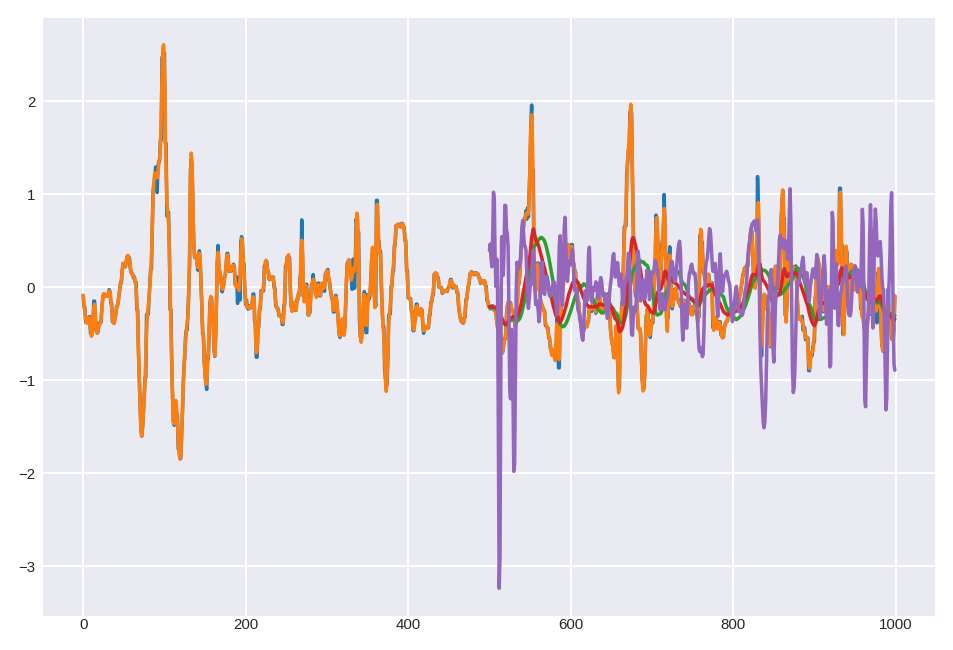

In [96]:
# This test was passed in earlier versions of the file, since we modifed prep_x_y and get_raw_windows_user_47, the test does not hold, as get_raw_windows_user_47 now takes care of the shorter
# stream length of user_47 data
if TEST_MODE:
    
#     user_ids = [1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49]
#     exp_begin_cutoff_idx = 500
#     exp_end_cutoff_idx = -500
#     num_sample_points_per_exp = 21000
#     df_exps_dict = load_data_frames(user_ids, exp_begin_cutoff_idx, exp_end_cutoff_idx, num_sample_points_per_exp)
#     dfList_exp1, dfList_exp2 = df_exps_dict['dfList_exp1'], df_exps_dict['dfList_exp2']
    
#     raw_dfList_exp1 = dfList_exp1
#     raw_dfList_exp2 = dfList_exp2

    smoothing = "FFT"
    cut_off_freq=25
    ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=cut_off_freq, filter_order=10, filtfilt=1)
    ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=cut_off_freq, filter_order=10, filtfilt=1)
    raw_dfList_exp2[0]['x_a'][0:1000].plot()
    ffted_dfList_exp2[0]['x_a'][0:1000].plot()
    # get_ffted_dfList([raw_dfList_exp2[0][raw_dfList_exp2[0].columns][500:1000]], cut_off_freq=P.cut_off_freq, filter_order=10)[0]['EMA_x_a'].plot()
    dfList_exp1 = ffted_dfList_exp1
    dfList_exp2 = ffted_dfList_exp2

    span=49
    # P.smoothing = "FFT+EMA"
    # # raw_dfList_exp1 = dfList_exp1
    # # raw_dfList_exp2 = dfList_exp2
    # P.cut_off_freq=42
    # ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=10)
    # ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=10)
    # ffted_dfList_exp2[0]['EMA_x_a'][500:1000].plot()
    EMAed_dfList_exp1 = get_EMAed_dfList(ffted_dfList_exp1, span=span)
    EMAed_dfList_exp2 = get_EMAed_dfList(ffted_dfList_exp2, span=span)
    # EMAed_dfList_exp2[0]['EMA_x_a'][500:1000].plot()
    # dfList_exp1 = EMAed_dfList_exp1
    # dfList_exp2 = EMAed_dfList_exp2
    raw_dfList_exp2[0]['x_a'][500:1000].rolling(window=30, min_periods=0).mean()[:].plot()
    raw_dfList_exp2[0]['x_a'][500:1000].ewm(span=30, adjust=False).mean()[:].plot()
    
    randomized_data_idx = list(range(len(user_ids)))
    random.Random(SEED).shuffle(randomized_data_idx)
    split_idx = 2 * (len(randomized_data_idx)//3) + 1
    train_set = randomized_data_idx[: split_idx]
    test_set = randomized_data_idx[split_idx: ]
    print(f"train_set: {train_set}\ntest_set: {test_set}")
    
    # preparing train data
    
    
    window_size = 500
    nn_step_width = window_size//2
    ocsvm_step_width = window_size//2
    scaler = "RobustScaler"


    # train_set = r
    exp1_df_train_dict, exp2_df_train_dict = {user_key: dfList_exp1[user_key] for user_key in train_set}, {user_key: dfList_exp2[user_key] for user_key in train_set}
    print(f"len(exp1_df_train_dict): {len(exp1_df_train_dict)}")
    print(f"len(exp2_df_train_dict): {len(exp2_df_train_dict)}")
    # Raw_X_Exp_Train_Dict = MakeRawXExpDic(exp1_df_train_dict, exp2_df_train_dict, window_size=P.window_size, step=P.nn_step_width, numSamplePoints=P.num_sample_points_per_exp, 
    #                                       scale_exp1=True, scale_exp2=True, scaler=P.scaler)
    # ---- new, realistic way
    Raw_X_Exp_Train_Dict = MakeRawXExpDict_old(exp1_df_train_dict, exp2_df_train_dict, window_size=window_size, step=nn_step_width, numSamplePoints=num_sample_points_per_exp, 
                                          scale_exp1=False, scale_exp2=True, scaler=scaler)

    fitted_scaler_SNN_exp2_train_dic = Raw_X_Exp_Train_Dict["fitted_scaler_exp2_dic"]
    # -----new
    Raw_X_exp1_train_dic, Raw_X_exp2_train_dic = Raw_X_Exp_Train_Dict["Raw_X_exp1_dic"], Raw_X_Exp_Train_Dict["Raw_X_exp2_dic"]

    # preparing test data
    exp1_df_test_dict, exp2_df_test_dict = {user_key: dfList_exp1[user_key] for user_key in test_set}, {user_key: dfList_exp2[user_key] for user_key in test_set}
    print(f"len(exp1_df_test_dict): {len(exp1_df_test_dict)}")
    print(f"len(exp2_df_test_dict): {len(exp2_df_test_dict)}")
    Raw_X_Exp_Test_Dict = MakeRawXExpDict_old(exp1_df_test_dict, exp2_df_test_dict, window_size=window_size, step=ocsvm_step_width, numSamplePoints=num_sample_points_per_exp, 
                                         scale_exp1=False, scale_exp2=True, scaler=scaler)

    fitted_scaler_ocsvm_exp2_dic = Raw_X_Exp_Test_Dict["fitted_scaler_exp2_dic"]
    Raw_X_exp1_test_dic, Raw_X_exp2_test_dic = Raw_X_Exp_Test_Dict["Raw_X_exp1_dic"], Raw_X_Exp_Test_Dict["Raw_X_exp2_dic"]



    num_sample_points_per_exp_user_47 = 18000
    df_exps_dict_user_47 = load_data_frames([47], exp_begin_cutoff_idx, exp_end_cutoff_idx, num_sample_points_per_exp_user_47)
    dfList_exp1_user_47, dfList_exp2_user_47 = df_exps_dict_user_47['dfList_exp1'], df_exps_dict_user_47['dfList_exp2']

    raw_dfList_exp1_user_47 = dfList_exp1_user_47
    raw_dfList_exp2_user_47 = dfList_exp2_user_47

    ffted_dfList_exp1_user_47 = get_ffted_dfList(raw_dfList_exp1_user_47, cut_off_freq=cut_off_freq, filter_order=10, filtfilt=1)
    ffted_dfList_exp2_user_47 = get_ffted_dfList(raw_dfList_exp2_user_47, cut_off_freq=cut_off_freq, filter_order=10, filtfilt=1)
    ffted_dfList_exp2_user_47[0]['x_a'][500:1000].plot()
    dfList_exp1_user_47 = ffted_dfList_exp1_user_47
    dfList_exp2_user_47 = ffted_dfList_exp2_user_47
    # EMAed_dfList_exp1_user_47 = get_EMAed_dfList(ffted_dfList_exp1_user_47, span=P.span)
    # EMAed_dfList_exp2_user_47 = get_EMAed_dfList(ffted_dfList_exp2_user_47, span=P.span)
    # EMAed_dfList_exp2_user_47[0]['EMA_x_a'][500:1000].plot()
    # dfList_exp1_user_47 = EMAed_dfList_exp1_user_47
    # dfList_exp2_user_47 = EMAed_dfList_exp2_user_47
    exp1_df_dict_user_47, exp2_df_dict_user_47 = {47: dfList_exp1_user_47[0]}, {47: dfList_exp2_user_47[0]}
    Raw_X_Exp_Train_Dict_user_47 = MakeRawXExpDict_old(exp1_df_dict_user_47, exp2_df_dict_user_47, window_size=window_size, step=nn_step_width, numSamplePoints=num_sample_points_per_exp_user_47, 
                                          scale_exp1=False, scale_exp2=True, scaler=scaler)

    fitted_scaler_SNN_exp2_train_dic_user_47 = Raw_X_Exp_Train_Dict_user_47["fitted_scaler_exp2_dic"]
    # -----new
    Raw_X_exp1_train_dic_user_47, Raw_X_exp2_train_dic_user_47 = Raw_X_Exp_Train_Dict_user_47["Raw_X_exp1_dic"], Raw_X_Exp_Train_Dict_user_47["Raw_X_exp2_dic"]



    user_47_idx = len(user_ids)
    print(user_47_idx)
    if user_47_idx not in train_set:
        train_set.append(user_47_idx)
    print(np.unique(train_set))
    user_47_key = user_47_idx
    Raw_X_Exp_Train_Dict["Raw_X_exp1_dic"][user_47_key] = Raw_X_Exp_Train_Dict_user_47["Raw_X_exp1_dic"][47]
    Raw_X_Exp_Train_Dict["Raw_X_exp2_dic"][user_47_key] = Raw_X_Exp_Train_Dict_user_47["Raw_X_exp2_dic"][47]
    Raw_X_Exp_Train_Dict['fitted_scaler_exp1_dic'][user_47_key] = Raw_X_Exp_Train_Dict_user_47['fitted_scaler_exp1_dic'][47]
    Raw_X_Exp_Train_Dict['fitted_scaler_exp2_dic'][user_47_key] = Raw_X_Exp_Train_Dict_user_47['fitted_scaler_exp2_dic'][47]

    print(Raw_X_Exp_Train_Dict['Raw_X_exp1_dic'].keys())
    fitted_scaler_SNN_exp2_train_dic = Raw_X_Exp_Train_Dict["fitted_scaler_exp2_dic"]
    # -----new
    Raw_X_exp1_train_dic, Raw_X_exp2_train_dic = Raw_X_Exp_Train_Dict["Raw_X_exp1_dic"], Raw_X_Exp_Train_Dict["Raw_X_exp2_dic"]


    spliter = 2*len(Raw_X_exp2_train_dic)//3
    cnn_train_exp2 = {key: Raw_X_exp2_train_dic[key] for key in list(Raw_X_exp2_train_dic.keys())[:spliter]}
    cnn_train_exp1 = {key: Raw_X_exp1_train_dic[key] for key in list(Raw_X_exp1_train_dic.keys())[:spliter]}
    cnn_valid_exp2 = {key: Raw_X_exp2_train_dic[key] for key in list(Raw_X_exp2_train_dic.keys())[spliter:]}
    cnn_valid_exp1 = {key: Raw_X_exp1_train_dic[key] for key in list(Raw_X_exp1_train_dic.keys())[spliter:]}


    print(f"train set: {cnn_train_exp2.keys()}\nvalidation set: {cnn_valid_exp2.keys()}")
    print(f"train set: {cnn_train_exp1.keys()}\nvalidation set: {cnn_valid_exp1.keys()}")


    X_exp1_dict, X_exp2_dict, fitted_scaler_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, window_size, nn_step_width, train_set[:-1], 
                                                                        scaler, num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None)

    X_exp1_dict_user_47, X_exp2_dict_user_47, fitted_scaler_exp2_dict_user_47=get_raw_windows_user_47(dfList_exp1_user_47, dfList_exp2_user_47, window_size, nn_step_width, 
                                                                                                      scaler=scaler, num_sample_points_per_exp=18000, 
                                                                                                      EMA_per_win_span=None, SMA_per_win_winsize=None)

    X_exp1_dict, X_exp2_dict, fitted_scaler_exp2_dict=append_user_47_to_data(X_exp1_dict, X_exp2_dict, fitted_scaler_exp2_dict, user_ids, X_exp1_dict_user_47, X_exp2_dict_user_47, 
                                                                             fitted_scaler_exp2_dict_user_47, verbose=1)

    
    
    # preparing test data
    X_test_exp1_dict, X_test_exp2_dict, fitted_scaler_test_exp2_dict=get_raw_windows(dfList_exp1, dfList_exp2, window_size, ocsvm_step_width, test_set, 
                                                                        scaler, num_sample_points_per_exp, EMA_per_win_span=None, SMA_per_win_winsize=None)

    assert fitted_scaler_SNN_exp2_train_dic.keys()==fitted_scaler_exp2_dict.keys()
    assert Raw_X_exp2_train_dic.keys()==X_exp1_dict.keys()
    assert Raw_X_exp1_train_dic.keys()==X_exp2_dict.keys()
    for user_key in Raw_X_exp2_train_dic:
        print(f"verifying user_key: {user_key}")
        for df_idx in range(len(Raw_X_exp2_train_dic[user_key])):
            try:
                assert_frame_equal(Raw_X_exp1_train_dic[user_key][df_idx], X_exp1_dict[user_key][df_idx])
                assert_frame_equal(Raw_X_exp2_train_dic[user_key][df_idx], X_exp2_dict[user_key][df_idx])
            except:
                print(f"user_key: {user_key}, df_idx: {df_idx}")
    # assert Raw_X_exp1_train_dic[1]==X_exp2_dict[1]
    print("no err train dicts")
    
    assert fitted_scaler_ocsvm_exp2_dic.keys()==fitted_scaler_test_exp2_dict.keys()
    assert Raw_X_exp2_test_dic.keys()==X_test_exp1_dict.keys()
    assert Raw_X_exp1_test_dic.keys()==X_test_exp2_dict.keys()
    for user_key in Raw_X_exp2_test_dic:
        print(f"verifying user_key: {user_key}")
        for df_idx in range(len(Raw_X_exp2_test_dic[user_key])):
            try:
                assert_frame_equal(Raw_X_exp1_test_dic[user_key][df_idx], X_test_exp1_dict[user_key][df_idx])
                assert_frame_equal(Raw_X_exp2_test_dic[user_key][df_idx], X_test_exp2_dict[user_key][df_idx])
            except:
                print(f"user_key: {user_key}, df_idx: {df_idx}")
    # assert Raw_X_exp1_train_dic[1]==X_exp2_dict[1]
    print("no err test dicts")